<code> MOVE REHABILITATION EXERCISES - ARTIFICIAL INTELLIGENCE RECOGNITION </code>
============================================================================

Shoulder rehabilitation exercises:
- <code> 1 | FE - upright active Flexion/Extension without a weight </code>
- <code> 2 | FEd - upright active Flexion/Extension with a weight </code>
- <code> 3 | ERs - Standing dumbbell (1 kg) External Rotation with shoulder abducted at 90° </code>
- <code> 4 | SL -  towel Slide</code>
- <code> 5 | EIR - External/Internal rotation self-assisted with a stick </code>
- <code> 6 | AA - Abduction/Adduction without a weight</code>

=============================================================================

IMPORT LIBRARIES

In [1]:
# Import for data Manipulation and Representation
import matplotlib.pyplot         as plt
import pandas                    as pd
import numpy                     as np
import seaborn                   as sns
import plotly.express            as px
import os
from sklearn.model_selection    import train_test_split
from sklearn.decomposition      import PCA

# Import Classifiers
from sklearn.neural_network     import MLPClassifier
from sklearn.metrics            import roc_auc_score, accuracy_score, recall_score, confusion_matrix, precision_score, recall_score, f1_score
from joblib                     import dump, load
from sklearn.svm                import SVC
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.ensemble           import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree               import DecisionTreeClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.naive_bayes        import GaussianNB
from sklearn.neural_network     import MLPClassifier

from sklearn.preprocessing      import StandardScaler

# Import Classifiers Metrics
from sklearn.metrics            import roc_curve,auc
from sklearn.model_selection    import KFold,GridSearchCV, RandomizedSearchCV,cross_val_score, ParameterGrid

#from google.colab import files

import pdb  #this is important for debugging
from scipy.io import savemat


np.random.seed(42)


**LOAD DATASET**

In [2]:
pathData = 'D:\DOTTORATO\MATLAB\MoveRehabilitation_AI\MachineLearning\Dataset_importPython'

#data = files.upload()
# IMPORT THE DATASET ON WHICH I TRAIN THE CLASSIFIERS
DatasetTraining = pd.read_csv(pathData+'\Dataset_Training.csv', delimiter=',')

# IMPORT THE DATASET ON WHICH I DO THE FINAL ASSESSMENT
DatasetTest = pd.read_csv(pathData+'\Dataset_Test.csv', delimiter=',')
#DatasetTest = files.upload()

In [3]:
n_campioni_Training = DatasetTraining.shape[0]
#numberofFeatures_Training = DatasetTraining.shape[1] - 2 # devo levare la prima colonna dove c'è l'identificativo del soggetto e l'ultima colonna corrispondente alle labels
#FeaturesTraining = DatasetTraining.iloc[:,1:(numberofFeatures_Training+1)]  # queste sono le features di training
#LabelsTraining = DatasetTraining.iloc[:,-1:] # queste sono le labels di training

#definisco un nuovo Dataset in cui levo solo la prima colonna associata all'ID del soggetto
DatasetTraining = DatasetTraining.drop('NumRep',axis='columns')
LabelsTraining = DatasetTraining['Label']
DatasetTraining = DatasetTraining.drop('Label',axis='columns')
DatasetTraining

classes = pd.Series(LabelsTraining)
Numclasses = classes.value_counts().shape[0] #Numclasses = 6
print(Numclasses)

6


In [4]:
#definisco un nuovo Dataset in cui levo solo la prima colonna associata all'ID del soggetto
DatasetTest = DatasetTest.drop('NumRep',axis='columns')
LabelsTest = DatasetTest['Label']
DatasetTest = DatasetTest.drop('Label',axis='columns')

classesT = pd.Series(LabelsTest)
Numclasses = classesT.value_counts().shape[0] #Numclasses = 6
print(Numclasses)

6


**Definition of Useful Variables**

In [1]:
all_best_clfs = dict()
use_pca       = True
columns       = np.arange(1,7,1) #labels
colormap      = 'Blues'

#nomi dei classificatori
clf_names = ['adaboost']
#clf_names = ['knn','decision_tree','random_forest','SVM_rbf','log_reg','adaboost']

num_classifier = len(clf_names)

#creo percorsi dove salvare dati
for idx_name in list(range(len(clf_names))):

  name = clf_names[idx_name]

  GeneralPath = clf_names[idx_name]
  if not os.path.exists('./'+GeneralPath):
    os.mkdir(GeneralPath)

  ## creo percorso per salvare i classificatori del ciclo interno
  #pathClassifierInn = clf_names[idx_name]+'/'+clf_names[idx_name]+'_classifierInner'
  #print(pathClassifierInn)
  #if not os.path.exists('./'+pathClassifierInn):
  #  os.mkdir('./'+pathClassifierInn)

  # creo percorso per salvare i classificatori del ciclo esterno
  pathClassifierOut = clf_names[idx_name]+'/'+clf_names[idx_name]+'_classifierOuter'
  print(pathClassifierOut)
  if not os.path.exists('./'+pathClassifierOut):
    os.mkdir('./'+pathClassifierOut)

  # creo percorso della pca
  pathPca = clf_names[idx_name]+'/'+clf_names[idx_name]+'_pca'
  if not os.path.exists('./'+pathPca):
    os.mkdir('./'+pathPca)

  # creo percorso dello scaler
  pathScaler = clf_names[idx_name]+'/'+clf_names[idx_name]+'_scaler'
  if not os.path.exists('./'+pathScaler):
    os.mkdir('./'+pathScaler)


# creo percorso per salvare i risultati
pathResults = 'Results'
if not os.path.exists('./'+ pathResults):
  os.mkdir('./' + pathResults)



NameError: name 'np' is not defined

DEFINITION OF THE FUNCTION FOR TH CONFUSION MATRIX

In [6]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

**FUNCTION OF FEATURE STANDARDIZATION**

In [7]:
def featurestandardizationMethod(train_data,
                                 test_data,
                                 clf_counter,
                                 name):

  pathScaler = name+'/'+name+'_scaler'

# importa lo standard scaler da scikitlearn
  scaler = StandardScaler()
  train_data_std = scaler.fit_transform(train_data)
  dump(scaler,pathScaler+'/'+f'scaler{clf_counter}.joblib')  #dump(scaler,f'knn/knn_scaler/scaler{clf_counter}.joblib')

  test_data_std = scaler.transform(test_data)

  return train_data_std, test_data_std


**FUNCTION OF FEATURE SELECTION**

In [8]:
def featureselectionMethod(train_data_std,
                           test_data_std,
                           name,
                           nameClassifier):

  pathpca = nameClassifier+'/'+nameClassifier+'_pca'

  #implement the pca
  variance = 0.98
  pca = PCA(variance,random_state=42)
  pca_data_train = pca.fit_transform(train_data_std)

  #dump(pca,'pca.joblib')
  #dump(pca,'knn/knn_pca/pca'+name+'.joblib')
  dump(pca,pathpca+'/'+f'pca'+name+'.joblib')

  exp_var = pca.explained_variance_ratio_
  exp_var_cumul = np.cumsum(exp_var)
  plt.title('PCA Analysis')
  plt.xlabel('# Components')
  plt.ylabel('Variance')
  plt.plot(exp_var_cumul)

  #applico la stessa trasformazione al test set, dopo aver addestrato il modello sui dati del training (.fit e .transform al training)
  pca_data_test = pca.transform(test_data_std)

  return pca_data_train,pca_data_test

METRIC OF PERFORMANCE

In [9]:
#
def MetricPerformance_multiclassProblem(y_true,
                                        y_pred,
                                        Numclasses):

  CMfinal = confusion_matrix(y_true,y_pred) #calcolo la matrice di confusione totale

  somma = 0 #somma è la somma dei campioni all'interno della CM
  for riga in CMfinal:
     for elemento in riga:
       somma += elemento


  OverallAccuracy = accuracy_score(y_true, y_pred) #Accuracy classification score (overall accuracy)
  #AveragedAccuracy = accuracy_score(y_true, y_pred,average='macro') #averaged accuracy
  F1score = f1_score(y_true, y_pred,average='macro') #F-beta score, with beta = 1 // In the multi-class case, this is the average of the F1 score of each class with weighting depending on the average parameter
  Precision = precision_score(y_true, y_pred,average='macro') # Precision score.
  Sensitivity = recall_score(y_true, y_pred,average='macro') # sensitivity or Recall score
  #Specificity =


  singleCM_tot = np.zeros((2,2,6))

 # singleCM[:,:,]

  #a partire dalla CM, creo diverse matrici di confusione per ogni classe
  for id in list(range(Numclasses)):
    # l'indice id va da 0 a 5

    listClasses = list(range(Numclasses))
    #print(listClasses)
    listClasses.remove(id) #levo
    #print('Update list: ',listClasses)

    singleCM = np.zeros((2, 2))
    singleCM[0,0] = CMfinal[id,id] #true positive
    singleCM[1,0] = np.sum(CMfinal[listClasses,id]) #false positive
    singleCM[0,1] = np.sum(CMfinal[id,listClasses]) #false negative
    singleCM[1,1] = somma-singleCM[0,0]-singleCM[1,0]-singleCM[0,1] #np.sum(CMfinal[listClasses,listClasses]) #false negative
    #print(singleCM)

    singleCM_tot[:,:,id] = singleCM

    #calcolo le metriche per ogni classe:
    #SingleAccuracy[id] = accuracy_score(y_true, y_pred)


  return CMfinal, OverallAccuracy, F1score, Precision, Sensitivity, singleCM_tot


In [10]:
# Il dataset è già diviso in training e test. Ora divido le features dalle labels.
# TRAINING TEST
# in maniera randomica split del dataset in train e test
#train_data, test_data, train_target, test_target = train_test_split(
#                                                                    DatasetTraining,
#                                                                    LabelsTraining,
#                                                                    test_size=0.3,
#                                                                    random_state=42
#                                                                    )

# prova: non divido più il datasetTraining in training e test.
train_data = DatasetTraining
train_target = LabelsTraining
test_data = DatasetTest
test_target = LabelsTest

print('Dimensioni di x_train:', train_data.shape)
print('Dimensioni di train_target:', train_target.shape)
print(type(train_data))


Dimensioni di x_train: (1182, 366)
Dimensioni di train_target: (1182,)
<class 'pandas.core.frame.DataFrame'>


In [11]:
# nested K-Fold cross validation
K_outer = 10 # Number folds of the outer cycle
K_inner = 5 # Number folds of the inner cycle

NameFoder = 'outerFolder' + str(K_outer) + '_innerFolder' + str(K_inner)
print(NameFoder)

# creo percorso per salvare i risultati della nested cross validation
pathResults_crossValStrategy = 'Results/'+ NameFoder
if not os.path.exists('./'+ pathResults_crossValStrategy):
    os.mkdir('./' + pathResults_crossValStrategy)

savemat(pathResults_crossValStrategy + '/trueLabels_test.mat', {"array": test_target})

outerFolder10_innerFolder5


In [12]:
# Metrics
ticks       = np.arange(1,K_outer+1,1)

# Data
x_train = train_data.to_numpy() #pca_data_train if use_pca else train_data_features_selection
labels  = train_target.to_numpy()
x_test  = test_data.to_numpy() #pca_data_test if use_pca else test_data_features_selection

# Nested 5-Fold Cross Validation for Parameters Optimization
inner_cv = KFold(n_splits=K_inner,shuffle=True,random_state=42)
outer_cv = KFold(n_splits=K_outer,shuffle=True,random_state=42)

In [13]:
print(x_test.shape)

(108, 366)


DEFINITION OF THE FUNCTION "GET CLASSIFIER"

In [14]:
def get_classifier(clf_name : str, params : dict, Numclasses = None, num_feat = None):
  r'''
  @
  '''

  #clf_names = ['knn','DT','rdm','SVM_rbf','log_reg','adaboost']

  # Estimator:
  if clf_name == 'knn':
    est  =  KNeighborsClassifier(**params)
  elif clf_name == 'SVM_rbf':
    est = SVC(**params, gamma = 'auto')
  elif clf_name == 'decision_tree':
    est = DecisionTreeClassifier(**params)
  elif clf_name == 'random_forest':
    est = RandomForestClassifier(**params)
  elif clf_name == 'NB':
    est = GaussianNB(**params)
  elif clf_name == 'adaboost':
    # definizione del classificatore base
    base_estimator = LogisticRegression()
    est = AdaBoostClassifier(**params,estimator=base_estimator)
  elif clf_name == 'log_reg':
    est = LogisticRegression(**params,max_iter=200,n_jobs=4)
  elif clf_name == 'grad_boost':
    est = GradientBoostingClassifier(**params)
  elif clf_name == 'mlp':
    vector = []
    value = num_feat

    while value >= Numclasses*2:
      vector.append(value)
      value //= 2

    vector.append(Numclasses*2)  # Include 12 in the vector

    vector.reverse()

    est = MLPClassifier(**params, hidden_layer_sizes = vector, solver = 'adam', max_iter = 500)

  return est

### NESTED CROSS VALIDATION STRATEGY

Implemented classifiers are:
1. <code>Support Vector Classifier</code>
2. <code>K-Neareast Neighbour Classifier</code>
3. <code>Decision Tree Classifier</code>
4. <code>Random Forest Classifier</code>
5. <code>AdaBoost Classifier</code>
6. <code>Logistic Regression Classifier</code>


TRAINING OF THE CLASSIFIER

name of the classifier is log_reg


Outer cycle equal to. 0


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.8967136150234741
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.89652759323235


Parametri estimatore: {'C': 0.001, 'solver': 'newton-cg'}

   Inner cycle equal to. 0
   Valor

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.8967136150234741
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8974665603685003


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.8967136150234741
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8867924528301887
   Inner cycle equal to. 4
   Valore di accuratezza per questa 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.8967136150234741
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8867924528301887
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8984099565949153


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8915094339622641
   Inner cycle equal to. 4
   Valore di accuratezza per questa 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8867924528301887
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8993489237310657


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8915094339622641
   Inner cycle equal to. 4
   Valore di accuratezza per questa 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8915094339622641
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9002923199574807


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9031180795464611


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa c

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9050004429090265


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9050004429090265


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9059394100451768


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9059349809549119


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9078129152272124


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9059349809549119


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.906873948091062


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9106386748161928


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9078173443174773


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9134600053149082


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9144034015413233


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9172247320400391


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9153423686774737


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9181681282664542


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9181681282664542


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9209850296749048


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238063601736204


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.910377358490566
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9256842944459208


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.910377358490566
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238063601736204


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.910377358490566
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9150943396226415
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9275666578084861


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9150943396226415
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.927571086898751


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9198113207547169
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9245283018867925
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9313358136238816


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9245283018867925
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9322792098502968


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9245283018867925
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9245283018867925
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9369829037115777


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9369873328018425


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398086633005581


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379262999379927


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398086633005581


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9245283018867925
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379262999379927


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9407476304367084


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9416954557533881


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9454557533882539


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9435778191159535


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473381167508194


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9454557533882542


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.94921605102312


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9482770838869697


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510984143856852


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9482770838869697


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510984143856852


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.950159447249535


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9520418106121002


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510984143856852


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539197448844007


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510984143856852


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.954858712020551


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9520373815218355


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557976791567011


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.954858712020551


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'newton-cg'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per que

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567366462928515


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.954858712020551


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567366462928515


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.954858712020551


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557976791567011


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9623704491097529


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9623704491097529


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595535477013021


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651873505182035


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595535477013021


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642483833820533


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614314819736025


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651873505182035


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614314819736025


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9623704491097529


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9623704491097529


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.963309416245903


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9623704491097529


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9765258215962441
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.963309416245903


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9765258215962441
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9623704491097529


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9765258215962441
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9623704491097529


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642483833820533


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642483833820533


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.963309416245903


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642483833820533


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642483833820533


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633138453361679


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642483833820533


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651873505182035


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651873505182035


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651873505182035


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9698866152892196


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651917796084684


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680086810169192


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9698866152892196


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651917796084684


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9698866152892196


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651917796084684


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9651917796084684


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per tutti i ci

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9689476481530693


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661307467446185

Per il ciclo esterno 0, i migliori HP sono: {'C': 0.3351602650938841, 'solver': 'lbfgs'}, ottenuti al ciclo for degli HP numero 200

Performance on the data of the outer validation set at the outer cycle n. 0
Acc= [0.957983193277311]
Sens= [0.961038961038961]


Outer cycle equal to. 1


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8732394366197183
   Inner cycle equal to. 3
   Valore di accuratezza 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8732394366197183
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8584905660377359
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8955664806448755


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8732394366197183
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8679245283018868
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8732394366197183
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8679245283018868
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8993356364602711


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8779342723004695
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9021702542297811


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8867924528301887
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9059349809549119


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8867924528301887
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9059349809549119


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9078084861369474


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8867924528301887
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.906873948091062


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8773584905660378
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9078129152272123


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9115732128620782


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8820754716981132
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9096952785897777


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8962264150943396
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8962264150943396
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9153423686774737


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8867924528301887
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9115776419523429


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9191070954026044


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9191070954026044


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9200460625387545


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'newton-cg'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per que

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9200460625387545


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9191115244928693


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9209850296749048


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9209850296749048


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238019310833554


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8962264150943396
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9237975019930905


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9009433962264151
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9266188324918062


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9056603773584906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9266232615820711


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9150943396226415
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9150943396226415
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9303924173974666


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9198113207547169
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9303924173974666


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9198113207547169
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9245283018867925
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9369740455310479


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9198113207547169
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9322747807600319


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9245283018867925
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9397953760297634


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9369740455310479


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9416777393923288


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9292452830188679
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9407343431659138


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9435601027548943


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9435601027548943


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445034989813094


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9454424661174595


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9482593675259101


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9339622641509434
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9482593675259101


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492027637523253


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9501417308884754


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492027637523253


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492027637523253


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9386792452830188
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9529674904774559


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9433962264150944
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9510851271148905


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.953910886703871


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539064576136063


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.953910886703871


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539064576136063


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.953910886703871


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9481132075471698
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9529674904774559


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567366462928515


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.953910886703871


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567366462928515


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9528301886792453
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548498538400214


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567366462928515


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557932500664365


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576800425192665


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557932500664365


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576800425192665


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557932500664365


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586190096554168


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557932500664365


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586190096554168


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9575471698113207
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557932500664365


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586190096554168


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567366462928515


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586190096554168


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567366462928515


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567366462928515


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576800425192665


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586190096554168


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576800425192665


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9716981132075472
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9716981132075472
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9716981132075472
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9716981132075472
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9716981132075472
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9716981132075472
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9716981132075472
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9716981132075472
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567277881123217


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567322172025866


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9669811320754716
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567322172025866


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567277881123217


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567322172025866


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557888209761716


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9557888209761716


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595446895207724


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576711843387369


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567322172025866


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567322172025866


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.957666755248472


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9576756134290016


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i ci

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586057223846222


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9622641509433962
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586145805651519

Per il ciclo esterno 1, i migliori HP sono: {'C': 0.3351602650938841, 'solver': 'lbfgs'}, ottenuti al ciclo for degli HP numero 200

Performance on the data of the outer validation set at the outer cycle n. 1
Acc= [0.957983193277311, 0.9747899159663865]
Sens= [0.961038961038961, 0.96875]


Outer cycle equal to. 2


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to.

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9097882894853399


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9097882894853399


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9107272566214899


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9107272566214899


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9154265213925059


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9135485871202056


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9154265213925059


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9154265213925059


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9182478518912216


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9163610594383913


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9220125786163523


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9201213570732572


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9229471166622375


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9220037204358225


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9248250509345379


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.923881654708123


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9267074142971033


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.924825050934538


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9295243157055542


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9276463814332535


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9323500752945344


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9304721410222341


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9323500752945344


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9314111081583842


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9361148020196651


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9361148020196651


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9389317034281159


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9389317034281159


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9408096377004164


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9408096377004164


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9426875719727168


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417486048365667


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445655062450171


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9436265391088672


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9455044733811675


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445655062450171


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9464434405173178


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9455044733811675


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492603419257684


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492647710160333


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530206395606342


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9502037381521836


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530162104703693


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511427052883338


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530162104703693


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9520772433342192


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530162104703693


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530162104703693


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548985738329347


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530162104703693


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577154752413854


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577154752413854


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586455841970059


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595934095136858


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595934095136858


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577066170608557


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cic

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362

Per il ciclo esterno 2, i migliori HP sono: {'C': 0.3351602650938841, 'solver': 'lbfgs'}, ottenuti al ciclo for degli HP numero 200

Performance on the data of the outer validation set at the outer cycle n. 2
Acc= [0.957983193277311, 0.9747899159663865, 0.9830508474576272]
Sens= [0.961038961038961, 0.96875, 0.9855072463768115]


Outer cycle equal to. 3


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.863849765258216
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8881743289928249


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8685446009389671
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8910000885818053


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8966338913987068


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8975772876251218


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8685446009389671
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8985162547612721


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8994552218974222


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.902272123305873


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9013331561697226


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9003897599433077


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.901328727079458


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9022676942156082


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9041456284879086


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9050845956240587


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9041500575781735


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9069625298963594


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9060279918504739


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9078970679422446


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9079059261227742


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9088404641686598


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9116617946673753


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9097750022145451


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9126007618035257


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9125963327132608


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9154220923022411


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.914478696075826


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per t

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9163654885286562


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9163566303481264


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9173044556648063


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9173000265745415


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9210647532996722


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9191868190273716


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9257773053414828


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238905128886528


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9267162724776332


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9276552396137834


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9314155372486491


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9304721410222341


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9361103729294002


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9361103729294002


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379927362919656


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9361103729294002


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379927362919656


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9370493400655505


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9389317034281159


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379883072017007


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398706705642661


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398706705642661


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417486048365667


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9408096377004164


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445655062450171


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9436265391088672


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473868367437328


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445655062450171


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9502037381521836


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473824076534679


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.952081672424484


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9502037381521836


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548985738329347


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.952081672424484


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548985738329347


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548985738329347


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577154752413854


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577199043316502


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762511


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.960536805740101


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.960536805740101


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.960536805740101


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605368057401009


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i ci

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362

Per il ciclo esterno 3, i migliori HP sono: {'C': 0.3351602650938841, 'solver': 'lbfgs'}, ottenuti al ciclo for degli HP numero 200

Performance on the data of the outer validation set at the outer cycle n. 3
Acc= [0.957983193277311, 0.9747899159663865, 0.9830508474576272, 0.9915254237288136]
Sens= [0.961038961038961, 0.96875, 0.9855072463768115, 0.9901960784313726]


Outer cycle equal to. 4


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.863849765258216
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8975905748959162


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.863849765258216
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8994729382584818


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.863849765258216
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9013553016210472


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9041722030294979


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9051111701656481


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8685446009389671
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9051111701656479


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8732394366197183
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8732394366197183
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9069891044379486


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.909810434936664


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9098060058463991


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9126317654353796


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9135707325715299


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9163876339799806


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9135707325715299


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8732394366197183
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8732394366197183
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9173266011161308


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9173266011161308


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8732394366197183
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8732394366197183
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9201479316148463


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9210868987509965


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8732394366197183
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9201479316148463


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9220258658871469


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9248427672955974


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9248427672955974


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9314155372486491


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9304765701124988


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9351714057932501


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9342324386570997


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9370493400655505


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379883072017007


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379883072017007


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.938927274337851


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417441757463016


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9436221100186021


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9436221100186021


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445610771547523


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473824076534679


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9464434405173178


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530206395606342


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.952081672424484


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548985738329347


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548985738329347


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567809371955001


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567809371955001


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577199043316502


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567809371955001


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577199043316502


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586588714678005


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.961480201966516


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9643015324652315


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9643015324652315


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.961484631056781


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.966179466737532


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605456639206308


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652404996013818


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605456639206306


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652404996013818


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614846310567808


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652404996013818


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633625653290814


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111169


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472673


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cic

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624235981929312

Per il ciclo esterno 4, i migliori HP sono: {'C': 0.3351602650938841, 'solver': 'lbfgs'}, ottenuti al ciclo for degli HP numero 200

Performance on the data of the outer validation set at the outer cycle n. 4
Acc= [0.957983193277311, 0.9747899159663865, 0.9830508474576272, 0.9915254237288136, 0.9576271186440678]
Sens= [0.961038961038961, 0.96875, 0.9855072463768115, 0.9901960784313726, 0.9560428849902535]


Outer cycle equal to. 5


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Va

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8994330764460979


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8994330764460979


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9031889449906989


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9013110107183984


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9041279121268492


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9031889449906989


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9060058463991496


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9050713083532642


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9069492426255646


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9069536717158295


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9088316059881301


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9069536717158296


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9078926388519799


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9078926388519799


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9107095402604305


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9116440783063158


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9125874745327309


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9125830454424662


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9135264416688813


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9144654088050315


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9154088050314465


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9154043759411816


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9172823102134823


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.917282310213482


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9182212773496324


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9182168482593674


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.921038178758083


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9200992116219329


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238550801665338


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9247940473026841


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9266719815749844


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9266719815749844


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9294888829834351


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9294888829834351


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9323102134821507


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9332580387988306


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.934197005934981


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9351359730711313


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9370139073434316


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379528744795819


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398308087518823


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.938891841615732


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9407697758880327


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398308087518824


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417087430241828


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417131721144477


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445389317034281


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445389317034281


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9454778988395784


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473558331118788


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492337673841792


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.948294800248029


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9501771636105942


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511161307467446


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511161307467446


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530029231995748


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530029231995748


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.953941890335725


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548852865621402


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.953941890335725


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567676499247055


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558242536982904


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577110461511207


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558242536982904


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567632208344407


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577021879705908


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577021879705908


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586455841970059


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633537071485516


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9812206572769953
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cic

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211

Per il ciclo esterno 5, i migliori HP sono: {'C': 0.3351602650938841, 'solver': 'lbfgs'}, ottenuti al ciclo for degli HP numero 200

Performance on the data of the outer validation set at the outer cycle n. 5
Acc= [0.957983193277311, 0.9747899159663865, 0.9830508474576272, 0.9915254237288136, 0.9576271186440678, 0.9745762711864406]
Sens= [0.961038961038961, 0.96875, 0.9855072463768115, 0.9901960784313726, 0.9560428849902535, 0.9753550543024226]


Outer cycle equal to. 6


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.920187793

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8591549295774648
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8867924528301887
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8909735140402162


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8685446009389671
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8732394366197183
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.895677207901497


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8984941093099478


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8994330764460979


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.8962264150943396
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9031889449906989


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9069536717158296


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9088316059881301


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.913535299849411


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9173000265745415


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.919182389937107


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9201213570732572


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.922938258481708


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9219992913455576


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9266941270263087


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.923877225617858


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9295110284347595


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.927633094162459


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9295110284347595


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9285720612986091


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.93138896270706


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9332668969793605


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9342102932057754


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9342058641155108


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9370360527947559


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379750199309062


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398529542032067


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.940791921339357


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9436132518380724


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445522189742226


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9454956152006379


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473735494729383


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9483169456993533


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9483169456993533


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511338471078041


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511338471078041


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9520772433342192


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530206395606342


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530162104703693


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530206395606342


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530162104703693


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539596066967844


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.971830985915493
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'newton-cg'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per ques

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577154752413854


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577154752413854


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633537071485516


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624147400124015


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624147400124015


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633537071485516


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633537071485516


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661706085570023


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661706085570023


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661706085570023


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680574010098326


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680574010098326


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680574010098326


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680574010098326


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642926742847019


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671184338736823


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.964288245194437


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9765258215962441
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cic

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9812206572769953
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.965231641420852

Per il ciclo esterno 6, i migliori HP sono: {'C': 0.3351602650938841, 'solver': 'lbfgs'}, ottenuti al ciclo for degli HP numero 200

Performance on the data of the outer validation set at the outer cycle n. 6
Acc= [0.957983193277311, 0.9747899159663865, 0.9830508474576272, 0.9915254237288136, 0.9576271186440678, 0.9745762711864406, 0.9661016949152542]
Sens= [0.961038961038961, 0.96875, 0.9855072463768115, 0.9901960784313726, 0.9560428849902535, 0.9753550543024226, 0.9725028058361391]


Outer cycle equal to. 7


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per i

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8403755868544601
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8928780228541058


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8497652582159625
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8450704225352113
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8928824519443707


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8497652582159625
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9014084507042254
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8450704225352113
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8928824519443707


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8685446009389671
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8685446009389671
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8985162547612721


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8732394366197183
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9061032863849765
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8685446009389671
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8985206838515369


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9022765523961379


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9154929577464789
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9107981220657277
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9041500575781735


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9116617946673753


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.914478696075826


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9126007618035257


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9163566303481266


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.914478696075826


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9061032863849765
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9172955974842768


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9154176632119763


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.921990433165028


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9191735317565772


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9229294003011782


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9198113207547169
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9229294003011782


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238727965275932


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238772256178581


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9257551598901586


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238772256178581


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9285764903888742


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9257551598901586


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9313978208875898


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9304588537514394


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9351536894321907


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9332757551598903


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9370404818850208


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9351625476127203


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.937979449021171


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.937979449021171


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9408007795198866


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9426875719727168


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9445655062450171


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9436265391088672


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473824076534679


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473824076534679


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492603419257686


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9483213747896183


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539551776065196


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530162104703693


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548985738329347


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.955837540969085


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577154752413854


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567765081052352


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775358


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577154752413854


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039509


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039509


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9596022676942155


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9596022676942155


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9596022676942155


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605456639206306


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9596022676942155


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614802019665161


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614802019665161


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9643015324652315


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9643015324652315


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9643015324652315


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9652360705111172


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614757728762513


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per t

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9661750376472671


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9680529719195677


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624191691026663


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633581362388165


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9858490566037735
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicl

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9671140047834175


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9642971033749668

Per il ciclo esterno 7, i migliori HP sono: {'C': 6.13590727341317, 'solver': 'newton-cg'}, ottenuti al ciclo for degli HP numero 301

Performance on the data of the outer validation set at the outer cycle n. 7
Acc= [0.957983193277311, 0.9747899159663865, 0.9830508474576272, 0.9915254237288136, 0.9576271186440678, 0.9745762711864406, 0.9661016949152542, 0.940677966101695]
Sens= [0.961038961038961, 0.96875, 0.9855072463768115, 0.9901960784313726, 0.9560428849902535, 0.9753550543024226, 0.9725028058361391, 0.9527972027972028]


Outer cycle equal to. 8


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1
   Valore di a

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8779342723004695
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8975595712640624


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8779342723004695
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8826291079812206
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.8984985384002127


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9009433962264151
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9041367703073788


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9050757374435291


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9050757374435291


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9088360350783949


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9069536717158296


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9078926388519799


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9088316059881301


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.912587474532731


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9056603773584906
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9088316059881301


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9135308707591461


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9144698378952963


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9154088050314465


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8826291079812206
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9144698378952963


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9219815749844982


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9201036407121977


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9229249712109133


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8873239436619719
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9210426078483479


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.925741872619364


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.910377358490566
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9247984763929488


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9266808397555144


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.925741872619364


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9285587740278147


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9150943396226415
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9276198068916646


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9304455664806449


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.93138896270706


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9323235007529453


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9323279298432101


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.935140402161396


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9360837983878112


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9370183364336965


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9370227655239614


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9245283018867925
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9370227655239614


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9379617326601115


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9389051288865267


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398440960226768


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398485251129418


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417264593852422


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417264593852422


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9426654265213926


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9436043936575427


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9436043936575427


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9765258215962441
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9454823279298431


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9765258215962441
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9454823279298431


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9765258215962441
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473602622021436


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9765258215962441
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473602622021436


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492470546549738


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9765258215962441
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492470546549738


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492470546549738


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9492470546549738


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.950190450881389


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.950190450881389


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511294180175393


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.950190450881389


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539507485162547


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530117813801045


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548897156524051


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530117813801045


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548897156524051


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9530117813801045


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567676499247055


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539507485162547


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577110461511206


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9548897156524049


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577110461511206


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558286827885553


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558286827885553


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558286827885553


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577110461511206


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577110461511206


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9624413145539906
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577110461511206


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586500132872707


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624058818318716


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614669146957215


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9765258215962441
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9671361502347418
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9624103109221366


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.971830985915493
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i ci

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9671361502347418
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9671361502347418
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9633492780582869


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.971830985915493
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9624413145539906
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211

Per il ciclo esterno 8, i migliori HP sono: {'C': 6.13590727341317, 'solver': 'newton-cg'}, ottenuti al ciclo for degli HP numero 301

Performance on the data of the outer validation set at the outer cycle n. 8
Acc= [0.957983193277311, 0.9747899159663865, 0.9830508474576272, 0.9915254237288136, 0.9576271186440678, 0.9745762711864406, 0.9661016949152542, 0.940677966101695, 0.9661016949152542]
Sens= [0.961038961038961, 0.96875, 0.9855072463768115, 0.9901960784313726, 0.9560428849902535, 0.9753550543024226, 0.9725028058361391, 0.9527972027972028, 0.9686948853615519]


Outer cycle equal to. 9


Parametri estimatore: {'C': 0.001, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.892018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8732394366197183
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9022809814864028


Parametri estimatore: {'C': 0.0011233240329780276, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8779342723004695
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8873239436619719
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8779342723004695
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9041589157587031


Parametri estimatore: {'C': 0.0012618568830660211, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8779342723004695
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8779342723004695
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.892018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9041589157587031


Parametri estimatore: {'C': 0.0014174741629268048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.8967136150234741
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9060368500310035


Parametri estimatore: {'C': 0.0015922827933410922, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.8967136150234741
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9014084507042254
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9292452830188679
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9060368500310035


Parametri estimatore: {'C': 0.001788649529057435, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9339622641509434
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9098015767561343


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9061032863849765
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9107405438922844


Parametri estimatore: {'C': 0.002009233002565048, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8826291079812206
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9107405438922846


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9135574453007351


Parametri estimatore: {'C': 0.002257019719633919, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9014084507042254
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9154929577464789
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9126184781645851


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9061032863849765
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9144964124368855


Parametri estimatore: {'C': 0.0025353644939701114, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8873239436619719
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9107981220657277
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9135574453007351


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9182522809814863


Parametri estimatore: {'C': 0.002848035868435802, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9107981220657277
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9173133138453362


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.92018779342723
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9191912481176366


Parametri estimatore: {'C': 0.0031992671377973846, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.892018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9191912481176366


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9210691823899371


Parametri estimatore: {'C': 0.003593813663804626, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9201302152537867


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9014084507042254
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9220081495260875


Parametri estimatore: {'C': 0.004037017258596553, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9154929577464789
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.8967136150234741
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9248826291079812
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9191912481176366


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9248826291079812
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.924825050934538


Parametri estimatore: {'C': 0.004534878508128582, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.92018779342723
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9107981220657277
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9295774647887324
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9238860837983879


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9386792452830188
   La media dei valori di accuratezza per questa coppia di HP 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9295243157055542


Parametri estimatore: {'C': 0.0050941380148163806, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.92018779342723
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9276463814332535


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9481132075471698
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9304677119319692


Parametri estimatore: {'C': 0.00572236765935022, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9295774647887324
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9433962264150944
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9295243157055542


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9342723004694836
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9342324386570999


Parametri estimatore: {'C': 0.006428073117284319, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9154929577464789
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9528301886792453
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9332890424306848


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9351714057932501


Parametri estimatore: {'C': 0.007220809018385464, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9389671361502347
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9248826291079812
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.92018779342723
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9575471698113207
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9351714057932501


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9398706705642661


Parametri estimatore: {'C': 0.008111308307896872, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9295774647887324
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9389317034281159


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417530339268316


Parametri estimatore: {'C': 0.009111627561154887, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9408096377004164


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9342723004694836
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9426920010629818


Parametri estimatore: {'C': 0.010235310218990263, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417486048365667


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.943630968199132


Parametri estimatore: {'C': 0.011497569953977356, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9436619718309859
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9342723004694836
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9417530339268314


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9455133315616973


Parametri estimatore: {'C': 0.01291549665014884, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9483568075117371
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9455133315616973


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9389671361502347
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9473912658339977


Parametri estimatore: {'C': 0.014508287784959394, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9483302329701481


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9436619718309859
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9483302329701481


Parametri estimatore: {'C': 0.016297508346206444, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9248826291079812
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9483302329701481


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9530516431924883
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511471343785987


Parametri estimatore: {'C': 0.01830738280295368, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9502081672424485


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511471343785987


Parametri estimatore: {'C': 0.020565123083486514, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511471343785987


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511471343785987


Parametri estimatore: {'C': 0.02310129700083159, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511471343785987


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9511471343785987


Parametri estimatore: {'C': 0.02595024211399736, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9389671361502347
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9502081672424485


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9539728939675791


Parametri estimatore: {'C': 0.029150530628251757, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9295774647887324
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9436619718309859
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9520949596952786


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9549118611037294


Parametri estimatore: {'C': 0.03274549162877728, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.953972893967579


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9342723004694836
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567897953760298


Parametri estimatore: {'C': 0.036783797718286326, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9577464788732394
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9549118611037292


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558463991496147


Parametri estimatore: {'C': 0.04132012400115337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9549074320134643


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558463991496147


Parametri estimatore: {'C': 0.046415888336127795, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558463991496147


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.052140082879996844, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9558463991496147


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.05857020818056667, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567853662857649


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.0657933224657568, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9624413145539906
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567853662857649


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.07390722033525779, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9811320754716981
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.08302175681319744, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.093260334688322, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9389671361502347
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9596022676942155


Parametri estimatore: {'C': 0.10476157527896651, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.11768119524349979, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9567853662857649


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.13219411484660287, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614802019665161


Parametri estimatore: {'C': 0.1484968262254465, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9436619718309859
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303659


Parametri estimatore: {'C': 0.1668100537200059, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614802019665161


Parametri estimatore: {'C': 0.1873817422860383, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614802019665161


Parametri estimatore: {'C': 0.21049041445120198, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614802019665161


Parametri estimatore: {'C': 0.23644894126454072, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e 

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.26560877829466867, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9577243334219151


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.298364724028334, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595978386039506


Parametri estimatore: {'C': 0.3351602650938841, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775356


Parametri estimatore: {'C': 0.37649358067924676, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595934095136858


Parametri estimatore: {'C': 0.4229242874389499, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9483568075117371
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586544423775356


Parametri estimatore: {'C': 0.4750810162102798, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.5336699231206307, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 0.5994842503189409, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.6734150657750821, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.7564633275546291, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.8497534359086438, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 0.9545484566618337, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.072267222010323, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.2045035402587825, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 1.3530477745798062, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 1.5199110829529332, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 1.7073526474706904, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 1.9179102616724888, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.959593409513686


Parametri estimatore: {'C': 2.1544346900318843, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.971830985915493
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 2.420128264794381, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 2.71858824273294, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 3.0538555088334154, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 3.4304692863149193, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9596022676942155


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 3.8535285937105273, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 4.328761281083057, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 4.862601580065354, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 5.462277217684343, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e per

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 6.13590727341317, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9716981132075472
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 6.892612104349695, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 7.742636826811269, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 8.697490026177835, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9577464788732394
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 9.770099572992246, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 10.974987654930567, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 12.32846739442066, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 13.848863713938718, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605323766498362


Parametri estimatore: {'C': 15.556761439304722, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 17.47528400007683, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 19.630406500402724, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 22.051307399030456, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 24.77076355991709, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 27.825594022071257, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 31.25715849688235, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605412348303657


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 35.11191734215127, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 39.442060594376564, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 44.30621457583877, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e p

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 49.770235643321136, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9577464788732394
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 55.90810182512222, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 62.80291441834247, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9596022676942155


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9614713437859864


Parametri estimatore: {'C': 70.54802310718645, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 79.24828983539169, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9596022676942155


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e pe

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9595889804234211


Parametri estimatore: {'C': 89.02150854450393, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654


Parametri estimatore: {'C': 100.0, 'solver': 'lbfgs'}

   Inner cycle equal to. 0
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9765258215962441
   Inner cycle equal to. 1
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9624413145539906
   Inner cycle equal to. 2
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9530516431924883
   Inner cycle equal to. 4
   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9669811320754716
   La media dei valori di accuratezza per questa coppia di HP e per tutti i ci

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9812206572769953
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9530516431924883
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9577464788732394
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9622641509433962
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9605279475595712


Parametri estimatore: {'C': 100.0, 'solver': 'saga'}

   Inner cycle equal to. 0


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 0 è: 0.9671361502347418
   Inner cycle equal to. 1


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 1 è: 0.9483568075117371
   Inner cycle equal to. 2


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 2 è: 0.9530516431924883
   Inner cycle equal to. 3


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 3 è: 0.9483568075117371
   Inner cycle equal to. 4


C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero 4 è: 0.9764150943396226
   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è: 0.9586633005580654

Per il ciclo esterno 9, i migliori HP sono: {'C': 6.13590727341317, 'solver': 'newton-cg'}, ottenuti al ciclo for degli HP numero 301

Performance on the data of the outer validation set at the outer cycle n. 9
Acc= [0.957983193277311, 0.9747899159663865, 0.9830508474576272, 0.9915254237288136, 0.9576271186440678, 0.9745762711864406, 0.9661016949152542, 0.940677966101695, 0.9661016949152542, 0.9745762711864406]
Sens= [0.961038961038961, 0.96875, 0.9855072463768115, 0.9901960784313726, 0.9560428849902535, 0.9753550543024226, 0.9725028058361391, 0.9527972027972028, 0.9686948853615519, 0.973196881091618]


Best Classifier is the one at the outer cycle n. 3
x_test_std.shape: (108, 366)
pca_x_test.shape: (108, 126)


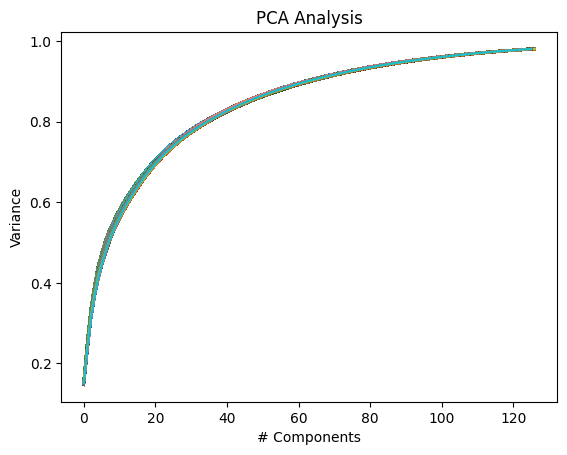

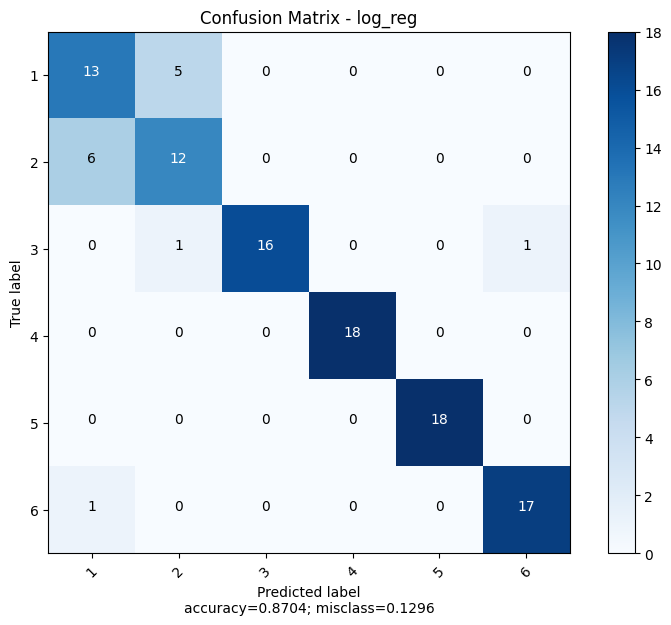


Performance on the indipendent dataset (30%) for the classifier log_reg are:
Accuracy= 0.8703703703703703
Sensitivity (recall)= 0.8727496846691892
Precision =  0.8768518518518519
F1score =  0.8703703703703703


In [15]:
#for nameClassifier in clf_names: # SCORRO IL NUMERO DI CLASSIFICATORI SCELTI
for idx_nameClassifier in list(range(len(clf_names))):

  nameClassifier = clf_names[idx_nameClassifier]

  clf_counter_outer = 0 # contatore del ciclo interno
  accuracies_outer  = [] # vettore in cui concateno i valori di accuratezza ottenuti applicando il classificatore sulla test fold esterna
  sensitivity_outer = [] # vettore in cui concateno i valori di sensitivity ottenuti applicando il classificatore sulla test fold esterna
  auc_scores  = []  # vettore in cui concateno i valori di auc ottenuti applicando il classificatore sulla test fold esterna
  tot_best_on_in = [] # vettore in cui concateno, per il ciclo i-esimo esterno, le migliori posizioni del ciclo interno

  print("")
  print('TRAINING OF THE CLASSIFIER')
  print("")
  print('name of the classifier is', nameClassifier)
  print("")

  if nameClassifier == 'knn':
    # Parameters to be optimized for the K-NEAREST NEIGHBOUR classifier
    n_neighbors = list(range(1, 20))
    param_grid = {'n_neighbors': n_neighbors, 'algorithm':['ball_tree', 'kd_tree', 'brute']}
  if nameClassifier == 'SVM_rbf':
    # Parameters to be optimized for the support vector machine classifier
    C_range = np.logspace(-3, 1, 50)
    param_grid = {'C': C_range, 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
  if nameClassifier == 'decision_tree':
    # Parameters to be optimized for the decision tree classifier
    param_grid = {'criterion':['gini', 'entropy', 'log_loss']}
  if nameClassifier == 'random_forest':
    # Parameters to be optimized for the random forest classifier
    n_estimators_range = range(30,500,10)
    param_grid = {'n_estimators': n_estimators_range, 'criterion':['gini', 'entropy', 'log_loss']}
  if nameClassifier == 'adaboost':
    # Parameters to be optimized for the adaboost classifier
    param_grid = {'n_estimators': [10, 50, 100, 150, 200], 'learning_rate': [0.001, 0.01, 0.1, 1.0]}
  if nameClassifier == 'log_reg':
    # Parameters to be optimized for the logistic regressor classifier are
    C_range = np.logspace(-3,2,100)
    param_grid = {'C': C_range, 'solver':['lbfgs', 'newton-cg', 'sag', 'saga']}
  if nameClassifier == 'mlp':
    # Parameters to be optimized for the logistic regressor classifier are
    learning_range = [1e-4, 1e-3, 1e-2, 1e-1, 1]
    param_grid = {'learning_rate_init': learning_range, 'activation':['logistic', 'tanh', 'relu']}


  #path del classificatore
  pathClassifierOutercycle = nameClassifier + '/' + nameClassifier + '_classifierOuter'
  #pathClassifierInnercycle = nameClassifier + '/' + nameClassifier + '_classifierInner'
  pathpca                  = nameClassifier + '/' + nameClassifier + '_pca'
  pathScaler               = nameClassifier + '/' + nameClassifier + '_scaler'
 
  # all_acc = np.zeros((K_outer,K_inner))
  best_acc_combo = 0  #Per ogni combinazione di iper parametri, eseguo i K cicli interni. Per ogni ciclo interno ho un valore di accuratezza accuracies_inner
                      # Faccio la media di questi K valori di accuratezza e ottengo avg_inner_acc. Confronto i valori medi di accuratezza ottenuti per ogni combo, e salvo il migliore valore in best_acc_combo.
  
  # Train/Test loop - OUTER LOOP
  for train_index, valid_index in outer_cv.split(x_train, train_target):
    
    params_combo_counter = 0 # contatore per tutte le possibili combo di iperparametri investigati
    all_pca_vector = np.zeros((1,K_inner))
    
    print("")
    print(f'Outer cycle equal to. {clf_counter_outer}')
    print("")

    # Outer Fold Split
    X_train_out, X_valid_out = x_train[train_index], x_train[valid_index]
    y_train_out, y_valid_out = labels[train_index],  labels[valid_index]

    #feature standardization
    train_data_std, test_data_std = featurestandardizationMethod(X_train_out,X_valid_out,clf_counter_outer,nameClassifier)

    for params in ParameterGrid(param_grid):
      
      clf_counter_inner = 0
      accuracies_inner  = np.zeros(K_inner)
      
     
      print(f'\nParametri estimatore: {params}') #stampo la coppia di parametri che sto andando ad ottimizzare
      print("")

      # Train/Test loop - INNER LOOP
      for train_index_inner, valid_index_inner in inner_cv.split(train_data_std, y_train_out):

        print(f'   Inner cycle equal to. {clf_counter_inner}')

        #print(f'\nParametri estimatore: {params}')

        # Inner Fold Split: training and validation
        X_train_in, X_valid_in = train_data_std[train_index_inner], train_data_std[valid_index_inner]
        y_train_in, y_valid_in = y_train_out[train_index_inner],  y_train_out[valid_index_inner]

        #feature selection: pca
        train_data_pca, test_data_pca = featureselectionMethod(X_train_in,X_valid_in,f'{clf_counter_outer}{params_combo_counter}',nameClassifier) #the output of this function are: train_data_pca, test_data_pca

        
        est_inner = get_classifier(nameClassifier,params, Numclasses, train_data_pca.shape[1]) if nameClassifier == 'mlp' else get_classifier(nameClassifier,params)

        # Train & Optimize on Inner K-Fold
        est_inner.fit(train_data_pca,y_train_in)

        # predizione sui campioni che appartengono al validation set interno
        y_pred_inner = est_inner.predict(test_data_pca)

        accuracies_inner[clf_counter_inner] = accuracy_score(y_valid_in, y_pred_inner)

        print(f'   Valore di accuratezza per questa coppia di HP e per il ciclo interno numero {clf_counter_inner} è:', accuracies_inner[clf_counter_inner])

        #dump(est,pathClassifierInnercycle+'/'+nameClassifier+f'{clf_counter_outer}{clf_counter_inner}.joblib') #dump(grid,f'knn/knn_classifier/knn{clf_counter_outer}{clf_counter_inner}.joblib')

        clf_counter_inner += 1
      
      avg_inner_acc = np.mean(accuracies_inner) # prestazioni del classificatore con quella combo di iperparametri
      print(f'   La media dei valori di accuratezza per questa coppia di HP e per tutti i cicli interni è:', avg_inner_acc)
      print("")

      if best_acc_combo < avg_inner_acc:
        best_acc_combo = avg_inner_acc
        best_params    = params
        best_counter_combo = params_combo_counter
      
      params_combo_counter += 1
     
    # Torno al ciclo esterno. Confronto i valori di accuratezza ottenuta nei diversi cicli interni. Prendo il max  
    print(f'Per il ciclo esterno {clf_counter_outer}, i migliori HP sono: {best_params}, ottenuti al ciclo for degli HP numero {best_counter_combo}')
    
    #best_on_in = np.argmax(accuracies_inner)
    #print(f'Best inner cycle is n. {best_on_in} at the outer cycle n. {clf_counter_outer}')

    tot_best_on_in.append(best_counter_combo) #salvo tutti gli indici

    #Dopo che ho visto in quale ciclo interno il classificatore ha ottenuto le performance migliori,
    #prendo quel classificatore, e prendo le feature associate a quella posizione
    #bestClassifier_innerCycle = load(pathClassifierInnercycle+'/'+nameClassifier+f'{clf_counter_outer}{best_on_in}.joblib') #load(f'knn/knn_classifier/knn{clf_counter_outer}{best_on_in}.joblib')

    bestpca_innerCycle = load(pathpca +'/'+ f'pca{clf_counter_outer}{best_counter_combo}'+'.joblib') #load(f'knn/knn_pca/pca{clf_counter_outer}{best_on_in}.joblib')

    #della matrice di features esterne, prendo solo quelle selezionate dalla pca
    X_train_selected = bestpca_innerCycle.transform(train_data_std)
    X_valid_selected = bestpca_innerCycle.transform(test_data_std)

    est_outer = get_classifier(nameClassifier,best_params, Numclasses, X_train_selected.shape[1]) if nameClassifier == 'mlp' else get_classifier(nameClassifier,best_params)

    est_outer.fit(X_train_selected,y_train_out)
    
    dump(est_outer,pathClassifierOutercycle + '/' + nameClassifier + f'{clf_counter_outer}.joblib')
    #dump(est_outer, f'{nameClassifier}{clf_counter_outer}_best.joblib')
    
    y_pred_outer = est_outer.predict(X_valid_selected)

    #performance classificatore --> sul validation set esterno
    accuracies_outer.append(accuracy_score(y_valid_out, y_pred_outer))
    #all_acc[clf_counter_outer,:] = accuracies_inner
    sensitivity_outer.append(recall_score(y_valid_out, y_pred_outer,average='macro'))

    print("")
    print(f'Performance on the data of the outer validation set at the outer cycle n. {clf_counter_outer}')
    print("Acc=", accuracies_outer)
    print("Sens=", sensitivity_outer)
    print("")

    clf_counter_outer += 1

  best_on_outer = np.argmax(accuracies_outer) 

  best_on_inner = tot_best_on_in[best_on_outer]

  print("")
  print(f'Best Classifier is the one at the outer cycle n. {best_on_outer}')

  best_est    = load(pathClassifierOutercycle + '/' + nameClassifier + f'{best_on_outer}.joblib')
  best_scaler = load(pathScaler+'/scaler'+f'{best_on_outer}.joblib') #load(f'knn/knn_scaler/scaler{best_on_out}.joblib')
  best_pca    = load(pathpca +'/'+ f'pca{best_on_outer}{best_on_inner}'+'.joblib') #load(f'knn/knn_pca/pca{best_on_out}{best_on_in}.joblib')

  x_test  = test_data.to_numpy() #pca_data_test if use_pca else test_data_features_selection
  #standardizzo e prendo le features
  x_test_std = best_scaler.transform(x_test)
  print(f'x_test_std.shape: {x_test_std.shape}')
  pca_x_test = best_pca.transform(x_test_std)
  print(f'pca_x_test.shape: {pca_x_test.shape}')

  #x_test_selected = best_feat
  predictions = best_est.predict(pca_x_test) #predizione sui campioni di test esterni (5 pazienti)

  savemat(pathResults_crossValStrategy + f'/predictedLabels_test_{nameClassifier}.mat', {"array": predictions})

  # calculate and Plot Confusion Matrix for performance evaluation (over test set)

  plot_confusion_matrix(confusion_matrix(test_target,predictions),columns,f'Confusion Matrix - {nameClassifier}',cmap=colormap,normalize=False)
  #all_best_clfs.update({'knn' : best})

  CM, Accuracy, Sensitivity, Precision, F1score, singleCM_tot  = MetricPerformance_multiclassProblem(test_target,predictions,Numclasses)
  print("")
  print(f'Performance on the indipendent dataset (30%) for the classifier {nameClassifier} are:')
  print("Accuracy=", Accuracy) #overall accuracy
  print("Sensitivity (recall)=", Sensitivity)
  #print("Specificity =", Specificity)
  print("Precision = ", Precision)
  print("F1score = ", F1score)

  # salvo le matrici di confusione:
  #tot_CM_classifier[idx_nameClassifier] = CM

  #savemat("confusionMatrix_Prova.mat", {"array": CM})
  savemat('./'+ pathResults_crossValStrategy + f'/confusion_matrix_{nameClassifier}.mat', {"array": CM})
   #name_ConfusionMatrix_classifier = (f'Confusion Matrix - {nameClassifier}')

  #print(singleCM_tot)